# Stock Price Prediction using LSTM

This notebook demonstrates how to build an LSTM (Long Short-Term Memory) neural network to predict Tesla stock prices. We'll go through data loading, feature engineering, normalization, model building, training, and evaluation.

## Step 1: Load the Data

First, we import pandas and load the Tesla stock dataset from the CSV file to examine its structure and contents.

In [11]:
import pandas as pd

dataset=pd.read_csv("data/Tasla_Stock_Updated_V2.csv")
dataset.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


## Step 2: Visualize Price Trends

We plot the Open and Close prices over time to understand the price movement patterns in the dataset.

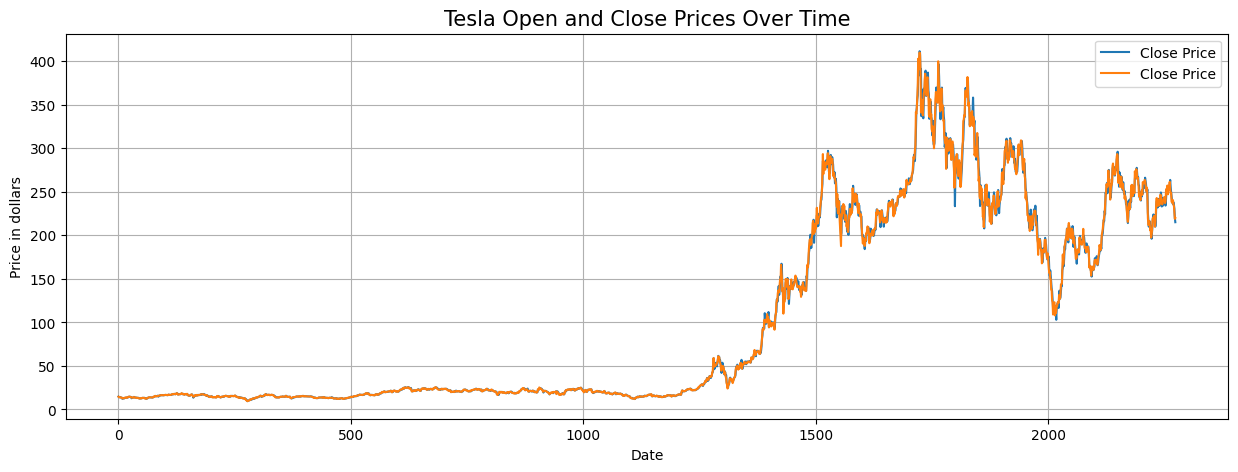

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))


plt.plot(dataset['Open'], label='Close Price')
plt.plot(dataset['Close'], label='Close Price')

plt.title('Tesla Open and Close Prices Over Time', fontsize=15)
plt.ylabel('Price in dollars')
plt.xlabel('Date')
plt.legend() 
plt.grid(True)
plt.show()

## Step 3: Explore Feature Distributions

We create histograms for all numeric features (Open, High, Low, Close, Volume) to understand their distributions.

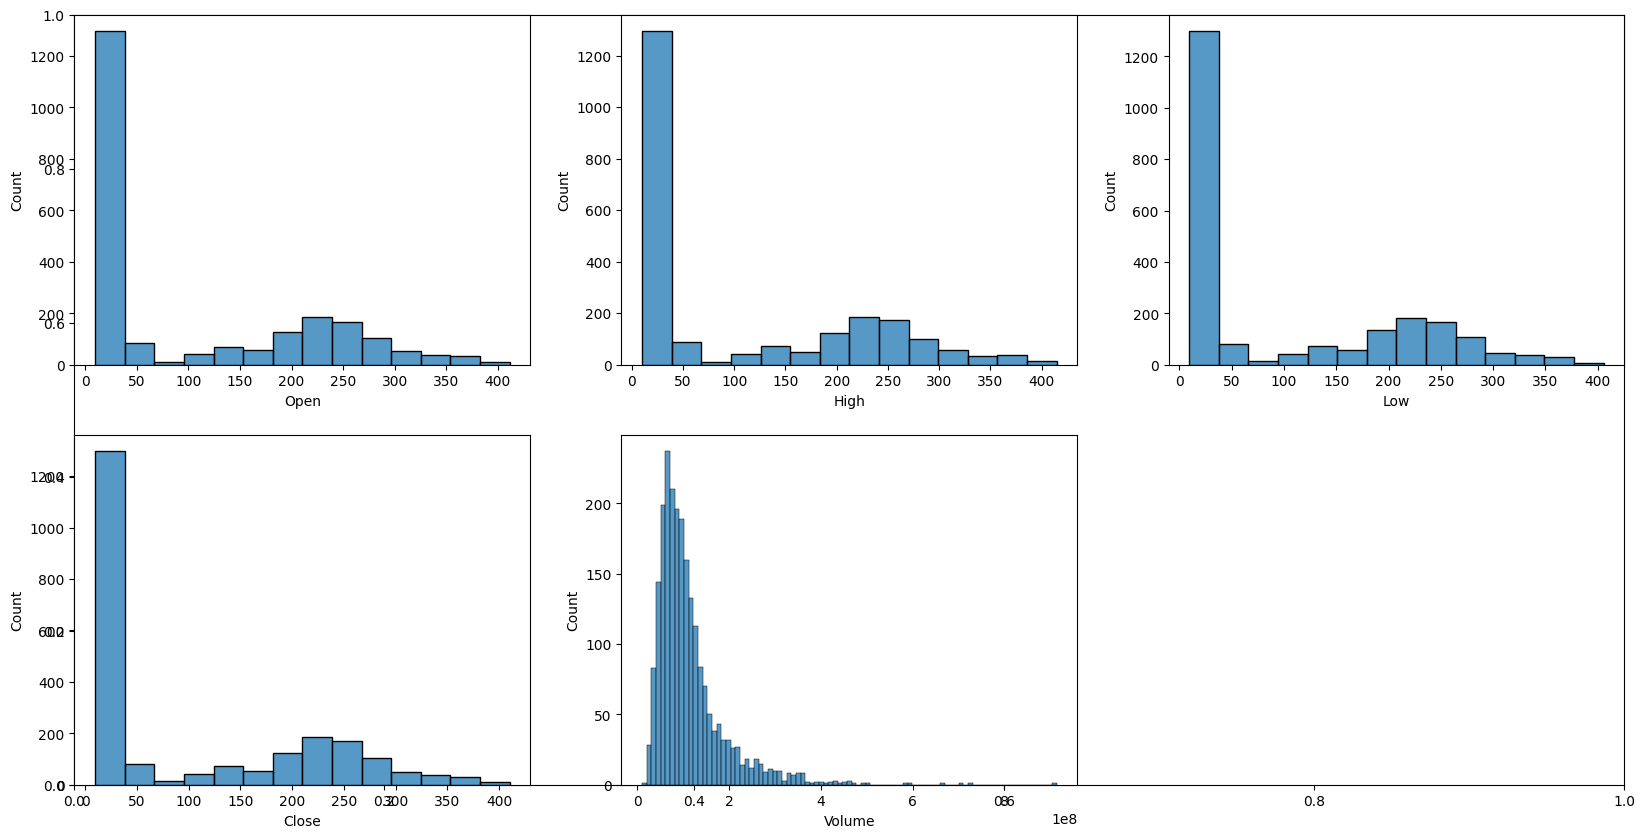

In [13]:
import seaborn as sns

features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.histplot(dataset[col])
plt.show()

## Step 4: Data Preprocessing

We remove unnecessary columns and set the Date as the index. This prepares the data for feature engineering.

In [14]:
dataset=dataset.drop(columns=["Unnamed: 0"], axis=1)
dataset = dataset.sort_values("Date")
dataset.set_index("Date", inplace=True)

## Step 5: Create Technical Indicators - Part 1

We engineer new features based on price movements:
- **Return**: Daily percentage change in closing price
- **High_Low**: Daily range (difference between high and low)
- **Open_Close**: Difference between opening and closing prices

In [15]:
dataset["Return"] = dataset["Close"].pct_change()
dataset["High_Low"] = dataset["High"] - dataset["Low"]
dataset["Open_Close"] = dataset["Open"] - dataset["Close"]

## Step 6: Create Technical Indicators - Part 2

We add Moving Averages which smooth price data to identify trends:
- **MA_5**: 5-day moving average
- **MA_20**: 20-day moving average

In [16]:
dataset["MA_5"] = dataset["Close"].rolling(5).mean()
dataset["MA_20"] = dataset["Close"].rolling(20).mean()

## Step 7: Create Technical Indicators - Part 3

We add more advanced indicators:
- **EMA_10**: 10-day Exponential Moving Average (gives more weight to recent prices)
- **Volatility_10**: 10-day rolling standard deviation of returns

In [17]:
dataset["EMA_10"] = dataset["Close"].ewm(span=10).mean()
dataset["Volatility_10"] = dataset["Return"].rolling(10).std()

In [18]:
dataset.head()

,Open,High,Low,Close,Volume,Return,High_Low,Open_Close,MA_5,MA_20,EMA_10,Volatility_10
Date,,,,,,,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000,NaN,0.666000,0.237332,NaN,NaN,14.620667,NaN
2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500,-0.042041,0.622666,0.297334,NaN,NaN,14.282600,NaN
2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500,0.005664,0.665999,-0.081333,NaN,NaN,14.203300,NaN
2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000,-0.001562,0.333334,0.160001,NaN,NaN,14.157187,NaN
2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500,-0.001564,0.252666,0.146000,14.163333,NaN,14.123928,NaN


## Step 8: Create Target Variable

We create the target variable by shifting the Close price forward by 1 day. The model will predict tomorrow's closing price based on today's features. We also remove rows with missing values.

In [19]:
dataset["Target"] = dataset["Close"].shift(-1)
dataset.dropna(inplace=True)

In [20]:
dataset.head()

,Open,High,Low,Close,Volume,Return,High_Low,Open_Close,MA_5,MA_20,EMA_10,Volatility_10,Target
Date,,,,,,,,,,,,,
2015-01-30,13.597333,13.831333,13.533333,13.573333,45105000,-0.007797,0.298000,0.024000,13.609333,13.550367,13.482536,0.019948,14.062667
2015-02-02,13.598000,14.130000,13.553333,14.062667,62238000,0.036051,0.576667,-0.464667,13.667867,13.522467,13.589597,0.022080,14.557333
2015-02-03,14.214667,14.691333,14.084667,14.557333,72393000,0.035176,0.606666,-0.342666,13.832933,13.550033,13.767704,0.022787,14.570000
2015-02-04,14.552667,14.765333,14.453333,14.570000,49581000,0.000870,0.312000,-0.017333,14.088667,13.574267,13.915034,0.022733,14.732667
2015-02-05,14.658667,15.032000,14.642667,14.732667,52843500,0.011165,0.389333,-0.074000,14.299200,13.607733,14.064908,0.022139,14.490667


## Step 9: Prepare Features and Scale Data

We separate features (X) from the target (y) and normalize the features using MinMaxScaler to bring all values to a 0-1 range. This helps the neural network train more effectively.

In [9]:
X=dataset.drop(columns=["Target"])
y=dataset["Target"]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Step 10: Split Data (First Attempt)

We split the data into training (80%) and testing (20%) sets without shuffling to preserve the time-series order.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [25]:
X_train[:4]

array([[0.01022268, 0.00865982, 0.01042236, 0.00997855, 0.03816984,
        0.49522066, 0.00300172, 0.40103795, 0.00947006, 0.00628483,
        0.00761707, 0.11360457],
       [0.01022434, 0.00939879, 0.01047284, 0.01120069, 0.05713356,
        0.60227864, 0.00814399, 0.39518518, 0.00961892, 0.00620774,
        0.00790796, 0.13165636],
       [0.01175841, 0.01078766, 0.0118137 , 0.01243614, 0.06837366,
        0.60014156, 0.00869756, 0.39664639, 0.01003871, 0.00628391,
        0.00839188, 0.13763681],
       [0.01259924, 0.01097076, 0.01274405, 0.01246778, 0.04312412,
        0.51638264, 0.00326006, 0.4005429 , 0.01068909, 0.00635088,
        0.00879218, 0.1371842 ]])

## Step 11: Define Sequence Creation Function

We create a helper function to transform the data into sequences. Instead of using single rows, we create sequences of 60 consecutive days of features to predict the next day's price. This is essential for LSTM which expects sequential data.

In [ ]:
import numpy as np

def create_sequences(X, y, lookback=60):
    X_seq = []
    y_seq = []

    for current_idx in range(lookback, len(X)): # start from the loopback index, as we take previous rows to form the first sequence.
        start_idx = current_idx - lookback
        end_idx = current_idx
        
        sequence_window = X[start_idx:end_idx] # Input sequence: the previous `lookback` rows of features.
        target_value = y[current_idx] # Target: the value at the current index (next day relative to the window).

        X_seq.append(sequence_window)
        y_seq.append(target_value)

    return np.array(X_seq), np.array(y_seq)

### Understanding the `create_sequences` Function

The `create_sequences` function transforms 1D time series data into sequences suitable for LSTM training. Here's how it works:

#### Function Purpose
- **Input**: Flat arrays of features (X) and targets (y)
- **Output**: 3D arrays where each sample is a sequence of past timesteps
- **Why**: LSTM expects sequences, not individual rows

#### How It Works
The function uses a **sliding window** approach with a `lookback` parameter (default: 60 days):

1. **Loop through data** starting from position `lookback` onwards
2. **Extract window**: Take the previous `lookback` days of features as one input sequence
3. **Get target**: Take the current row's target value
4. **Store pair**: Add (sequence, target) to the output lists

#### Example with lookback=3:
```
Original Data (6 rows):
Row 0: [0.1, 0.2]
Row 1: [0.3, 0.4]
Row 2: [0.5, 0.6]
Row 3: [0.7, 0.8]
Row 4: [0.9, 1.0]
Row 5: [1.1, 1.2]

Sequence 1: rows[0:3] → [[0.1,0.2], [0.3,0.4], [0.5,0.6]] → predict row[3]
Sequence 2: rows[1:4] → [[0.3,0.4], [0.5,0.6], [0.7,0.8]] → predict row[4]
Sequence 3: rows[2:5] → [[0.5,0.6], [0.7,0.8], [0.9,1.0]] → predict row[5]
```

#### Output Shapes
- **X_seq shape**: (n_sequences, lookback, n_features)
  - n_sequences: number of sequences created (len(X) - lookback)
  - lookback: 60 days of historical data
  - n_features: 12 (our engineered features)
  
- **y_seq shape**: (n_sequences,)
  - One target value per sequence

## Step 12: Scale Features and Target Separately

We scale both the features and target variable independently using MinMaxScaler. The target is reshaped to 2D format required by the scaler.

In [66]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

## Step 13: Scale Data Again (Note: This appears to be a duplicate of Step 12)

This cell repeats the scaling process. In practice, you could remove this duplication.

In [68]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

## Step 14: Create Sequential Data

We use the function from Step 11 to convert our scaled data into sequences of 60 days, creating the format needed for LSTM input.

In [69]:
X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback=60) 

## Step 15: Inspect Sequences

We examine the shape and content of our first sequence to verify the data format is correct.

In [70]:
X_seq[:1],y_seq[:1]

(array([[[0.01022268, 0.00865982, 0.01042236, 0.00997855, 0.03816984,
          0.49522066, 0.00300172, 0.40103795, 0.00947006, 0.00628483,
          0.00761707, 0.11360457],
         [0.01022434, 0.00939879, 0.01047284, 0.01120069, 0.05713356,
          0.60227864, 0.00814399, 0.39518518, 0.00961892, 0.00620774,
          0.00790796, 0.13165636],
         [0.01175841, 0.01078766, 0.0118137 , 0.01243614, 0.06837366,
          0.60014156, 0.00869756, 0.39664639, 0.01003871, 0.00628391,
          0.00839188, 0.13763681],
         [0.01259924, 0.01097076, 0.01274405, 0.01246778, 0.04312412,
          0.51638264, 0.00326006, 0.4005429 , 0.01068909, 0.00635088,
          0.00879218, 0.1371842 ],
         [0.01286293, 0.01163055, 0.01322185, 0.01287405, 0.04673523,
          0.5415169 , 0.00468709, 0.3998642 , 0.01122451, 0.00644336,
          0.0091994 , 0.1321492 ],
         [0.01321452, 0.01128746, 0.01269358, 0.01226964, 0.04210304,
          0.47415324, 0.00599112, 0.40445538, 0.0116910

## Step 16: Create PyTorch Dataset Class

We define a custom Dataset class to wrap our sequences for use with PyTorch's DataLoader, converting numpy arrays to PyTorch tensors.

In [72]:
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Step 17: Split Sequential Data

We split the sequential data into training (80%) and testing (20%) sets, preserving the temporal order.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

## Step 18: Create DataLoaders

We create DataLoader objects for both training and testing sets. DataLoaders handle batching and shuffling (disabled for time-series) to efficiently feed data to the model.

In [74]:
from torch.utils.data import DataLoader

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Step 19: Define LSTM Model Architecture

We define our LSTM neural network model with:
- An LSTM layer with configurable hidden size and number of layers
- A fully connected layer that outputs a single price prediction
- Dropout to prevent overfitting

In [75]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out

## Step 20: Initialize the Model

We instantiate the LSTM model with our chosen hyperparameters and move it to GPU (if available) for faster training. The input size is 12 because we have 12 features after feature engineering.

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(
    input_size=12,  # Updated to match the number of features in X
    hidden_size=64,
    num_layers=2,
    dropout=0.2
).to(device)

## Step 21: Define Loss Function and Optimizer

We use Mean Squared Error (MSE) as our loss function and Adam optimizer to update model weights during training.

In [81]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Step 22: Train the Model

We train the LSTM model for up to 40 epochs with early stopping. The model will stop training if the loss doesn't improve for 5 consecutive epochs to prevent overfitting and save time.

In [82]:
epochs = 40
best_loss = float("inf")
patience = 5
trigger_times = 0

for epoch in range(epochs):

    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}")

    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        trigger_times = 0
    else:
        trigger_times += 1

        if trigger_times >= patience:
            print("Early stopping triggered")
            break

Epoch 1, Train Loss: 0.019856
Epoch 2, Train Loss: 0.074363
Epoch 3, Train Loss: 0.014713
Epoch 4, Train Loss: 0.009833
Epoch 5, Train Loss: 0.001087
Epoch 6, Train Loss: 0.001362
Epoch 7, Train Loss: 0.001285
Epoch 8, Train Loss: 0.001226
Epoch 9, Train Loss: 0.001127
Epoch 10, Train Loss: 0.001229
Early stopping triggered


## Step 23: Generate Predictions on Test Set

We set the model to evaluation mode and make predictions on the test data without calculating gradients (more efficient).

In [83]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)

        outputs = model(X_batch)

        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.numpy())

## Step 24: Combine All Predictions and Actuals

We stack all batch predictions and actual values from the test set into single arrays for evaluation.

In [84]:
predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

## Step 25: Evaluate Model Performance

We calculate the Mean Absolute Error (MAE) on the test set to measure how far off our predictions are from actual prices on average. This metric is in the same units as the target variable (dollars).

In [86]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actuals, predictions)
print("MAE:", mae)

MAE: 0.03695053234696388
